In [14]:
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from src.data_utils import LabelledTraitData
from models.gbdt_bands_only import GBDTBandsOnly
from models.gbdt_aux_vars import GBDTAuxAndBands

In [3]:
VARS = [
    'N.Percent',
    'P.Percent',
    'K.Percent',
    'Ca.Percent',
    'Mg.Percent',
    'C.Percent',
    'Amax',
    'Asat',
    'Area.cm2',
    'Dry.mass.g',
    'Fresh.mass.g',
    'Thickness.mm',
    'SLA.g.m2'
]

In [12]:
def plot_residuals(y_test: pd.DataFrame, predictions: pd.DataFrame, var: str):
    """Plot residuals."""
    residuals = y_test.astype(np.float32) - predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals)
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.title(var)
    return plt.gca()

In [4]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 0.5]
}

In [6]:
bands_only_best_params = {}
bands_only_best_estimators = {}

for var in VARS:
    dataset = LabelledTraitData(
        data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
        var=var
    )

    X_train, y_train = dataset.train_data, dataset.train_labels
    X_test, y_test = dataset.test_data, dataset.test_labels

    X_train, y_train = GBDTBandsOnly.configure_data(X_train, y_train)
    X_test, y_test = GBDTBandsOnly.configure_data(X_test, y_test)

    # Initialize GridSearchCV
    rf = GradientBoostingRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

    # Fit the model to the training data
    grid_search.fit(X_train, y_train)

    bands_only_best_params[var] = grid_search.best_params_
    bands_only_best_estimators[var] = grid_search.best_estimator_

In [7]:
# Count the best parameters for each variable
param_counts = {}
for var, params in bands_only_best_params.items():
    for param, value in params.items():
        dataset = LabelledTraitData(
            data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
            var=var
        )
        X_test, y_test = GBDTBandsOnly.configure_data(dataset.test_data, dataset.test_labels)

        # Weight value by estimator score
        best_score = bands_only_best_estimators[var].score(X_test, y_test)
        if param in param_counts:
            if value in param_counts[param]:
                param_counts[param][value] += best_score
            else:
                param_counts[param][value] = best_score
        else:
            param_counts[param] = {value: best_score}

# Get the most common parameter values weighted by score.
sorted_params = {param: sorted(val.items(), key=lambda x: x[1], reverse=True) for param, val in param_counts.items()}
for param, values in sorted_params.items():
    print(f"Best value for {param}: {values[0][0]} with score {values[0][1]:.2f}")

bands_only_optim_params = {par: val[0][0] for par, val in sorted_params.items()}

Best value for learning_rate: 0.05 with score 3.48
Best value for max_features: 0.5 with score 3.19
Best value for n_estimators: 500 with score 2.57
Best value for subsample: 0.8 with score 3.97


In [8]:
bands_only_optim_params

{'learning_rate': 0.05,
 'max_features': 0.5,
 'n_estimators': 500,
 'subsample': 0.8}

Best parameters: {'learning_rate': 0.05, 'max_features': 'sqrt', 'n_estimators': 500, 'subsample': 0.8}
R-squared: 0.64


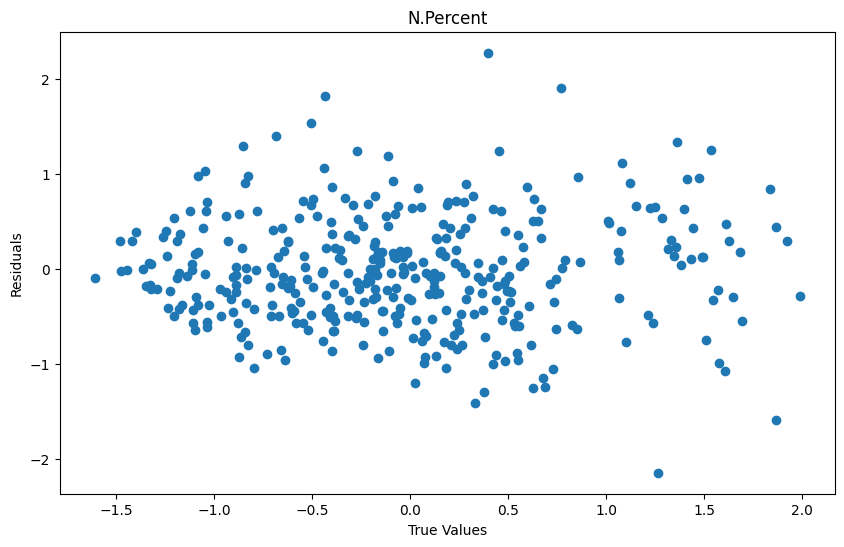

Best parameters: {'learning_rate': 0.05, 'max_features': 'sqrt', 'n_estimators': 500, 'subsample': 0.8}
R-squared: 0.44


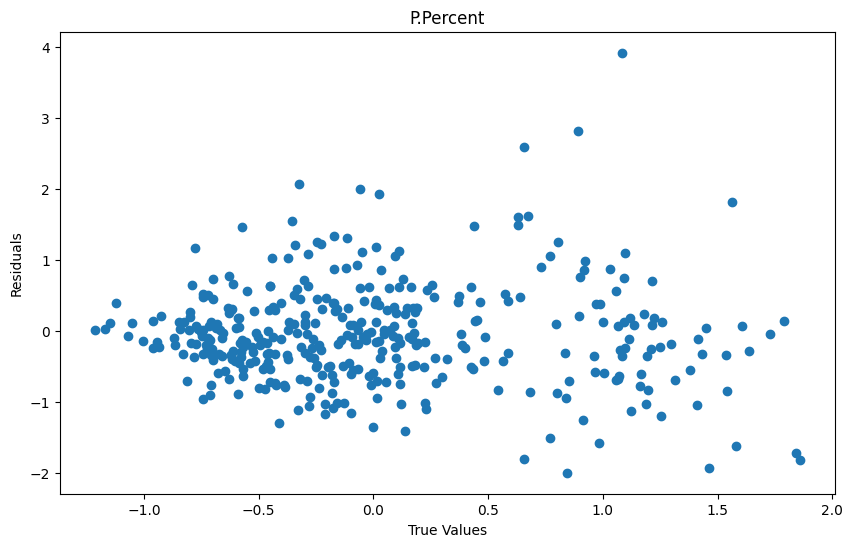

Best parameters: {'learning_rate': 0.1, 'max_features': 0.5, 'n_estimators': 300, 'subsample': 0.8}
R-squared: 0.35


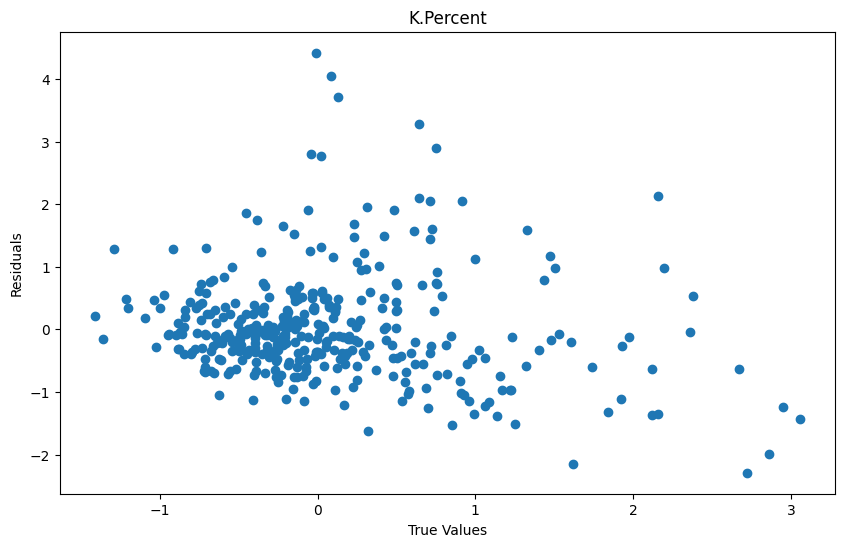

Best parameters: {'learning_rate': 0.1, 'max_features': 0.5, 'n_estimators': 300, 'subsample': 0.8}
R-squared: 0.73


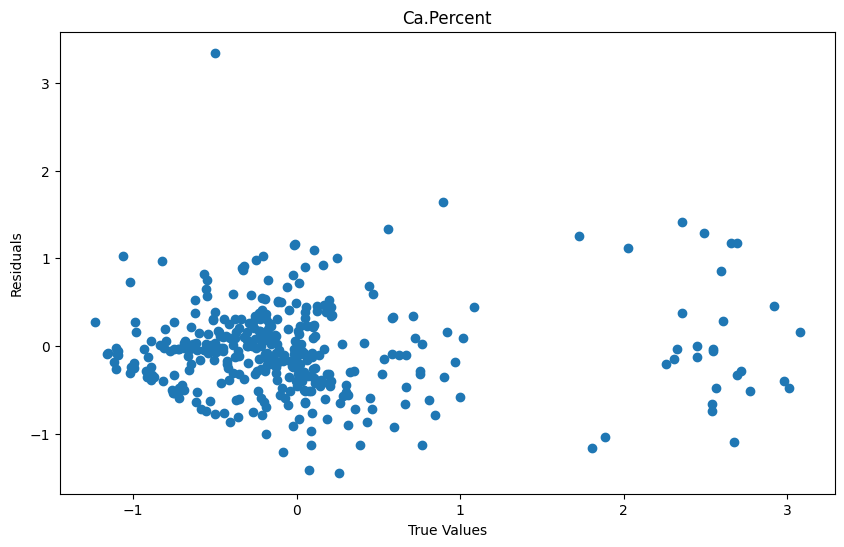

Best parameters: {'learning_rate': 0.05, 'max_features': 'sqrt', 'n_estimators': 500, 'subsample': 1.0}
R-squared: 0.27


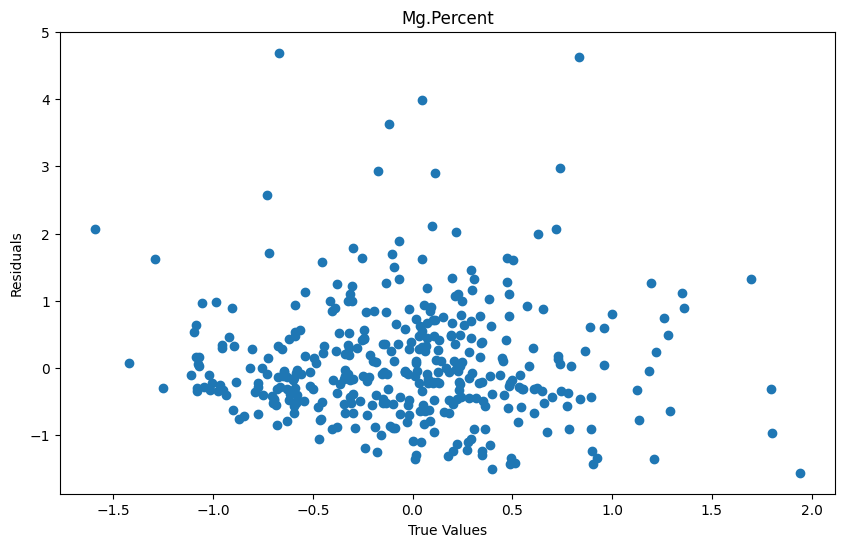

Best parameters: {'learning_rate': 0.05, 'max_features': 0.5, 'n_estimators': 500, 'subsample': 0.8}
R-squared: 0.50


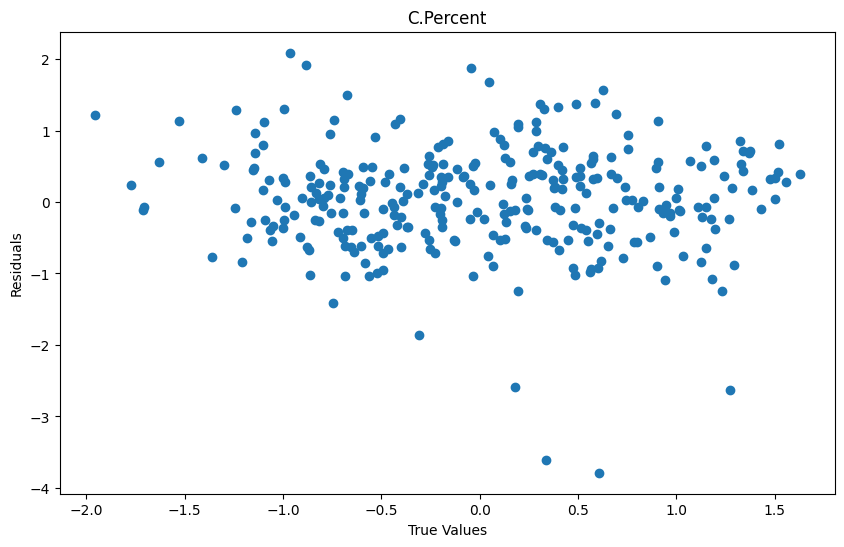

Best parameters: {'learning_rate': 0.05, 'max_features': 0.5, 'n_estimators': 300, 'subsample': 1.0}
R-squared: 0.63


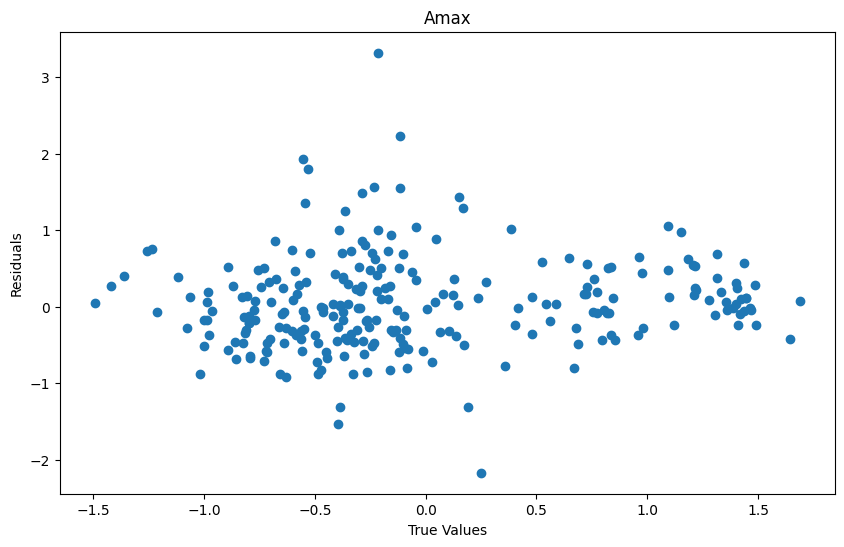

Best parameters: {'learning_rate': 0.1, 'max_features': 0.5, 'n_estimators': 100, 'subsample': 1.0}
R-squared: 0.40


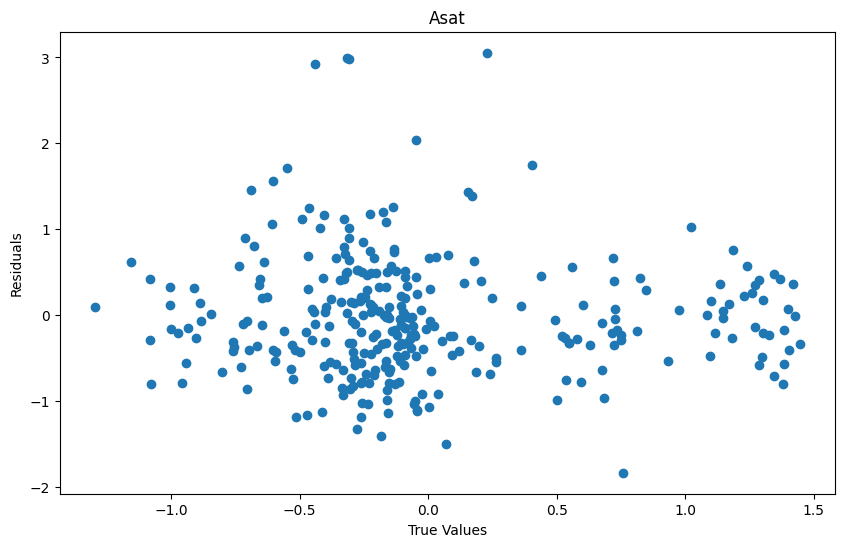

Best parameters: {'learning_rate': 0.05, 'max_features': 0.5, 'n_estimators': 300, 'subsample': 0.8}
R-squared: 0.33


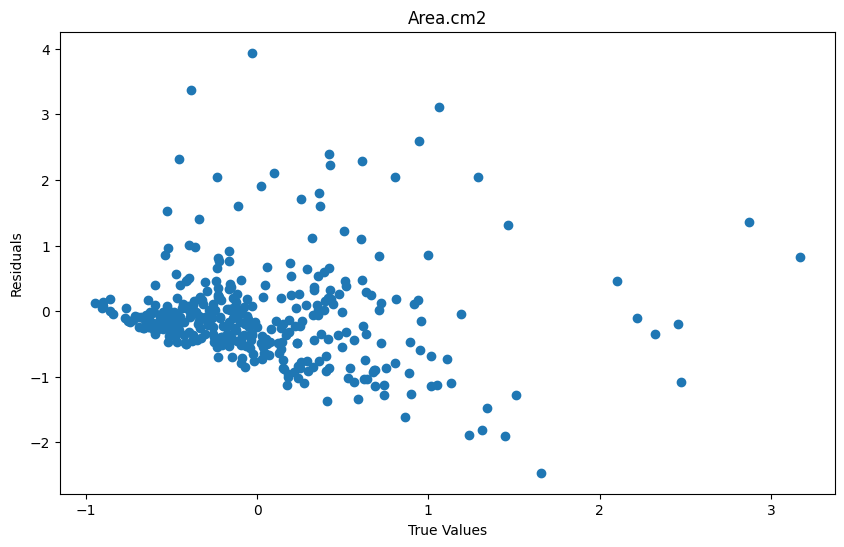

Best parameters: {'learning_rate': 0.01, 'max_features': 'sqrt', 'n_estimators': 500, 'subsample': 0.8}
R-squared: 0.11


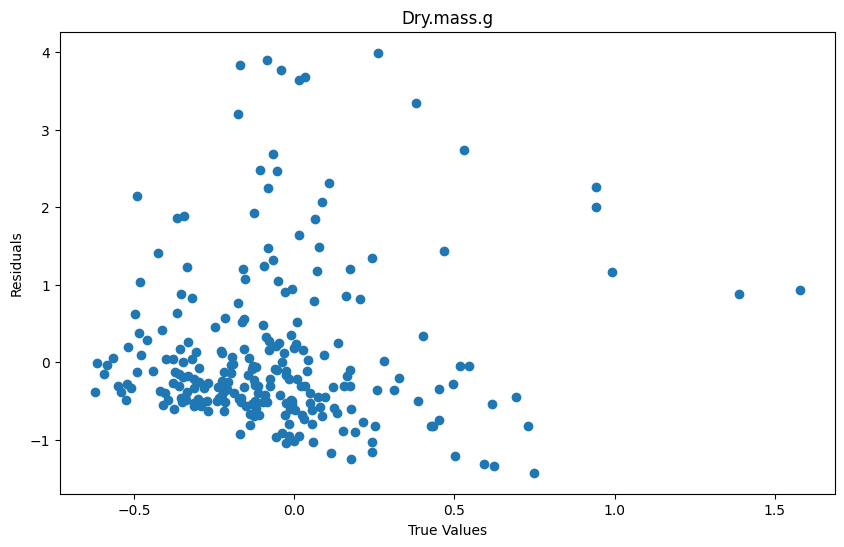

Best parameters: {'learning_rate': 0.01, 'max_features': 'sqrt', 'n_estimators': 500, 'subsample': 0.8}
R-squared: 0.20


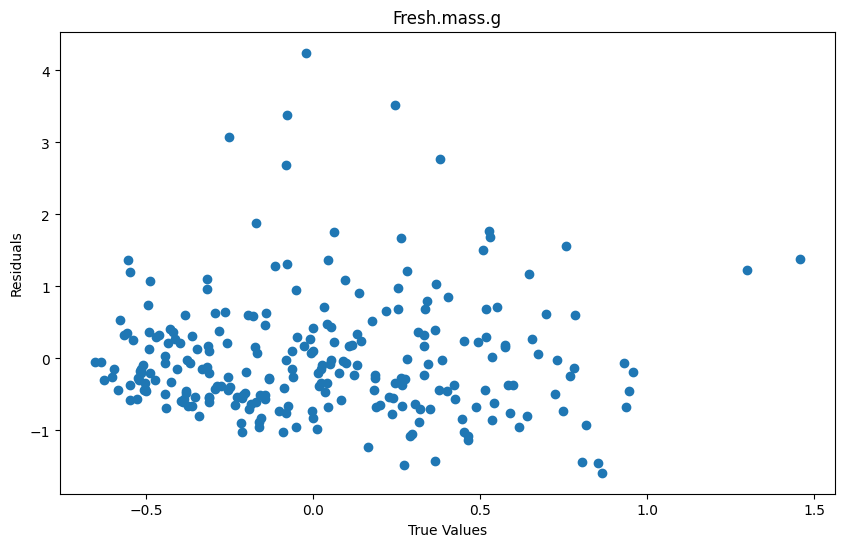

Best parameters: {'learning_rate': 0.05, 'max_features': 'sqrt', 'n_estimators': 500, 'subsample': 0.8}
R-squared: 0.41


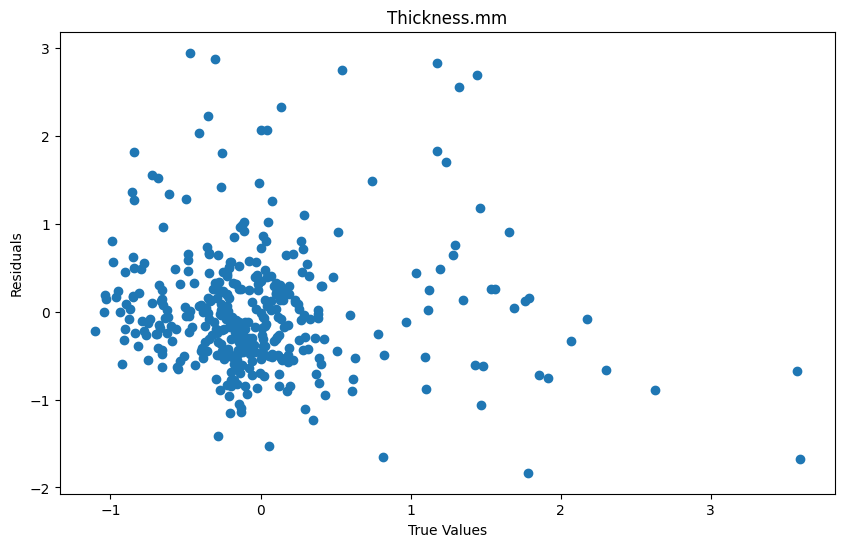

Best parameters: {'learning_rate': 0.05, 'max_features': 0.5, 'n_estimators': 300, 'subsample': 0.8}
R-squared: 0.26


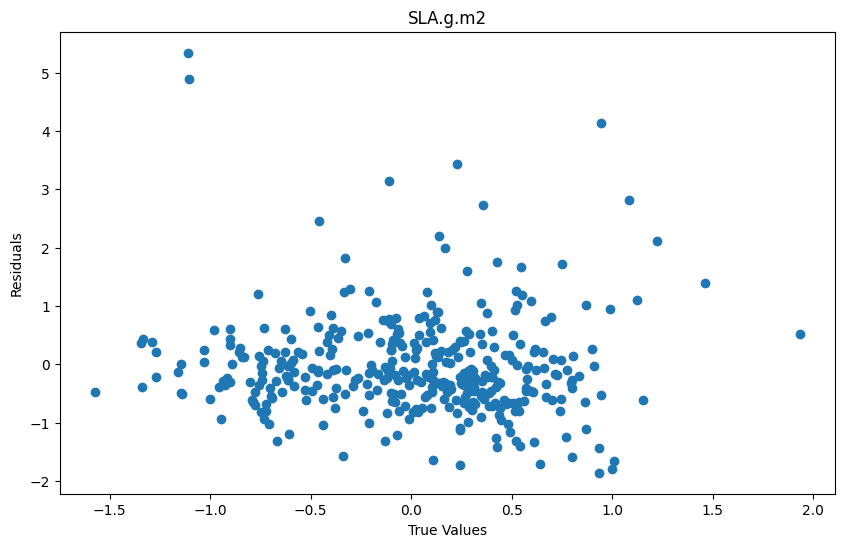

In [15]:
for var in VARS:
    dataset = LabelledTraitData(
        data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
        var=var
    )

    X_test, y_test = GBDTBandsOnly.configure_data(dataset.test_data, dataset.test_labels)

    # Get the best parameters
    best_params = bands_only_best_params[var]
    print(f"Best parameters: {best_params}")
    # Get the best model
    best_rf = bands_only_best_estimators[var]
    # Predict the trait values
    predictions = best_rf.predict(X_test)
    # Calculate metrics.
    r_squared = best_rf.score(X_test, y_test)
    print(f"R-squared: {r_squared:.2f}")

    fig = plot_residuals(y_test, predictions, var)
    plt.savefig(f"../figures/models/residuals_{var}_GBDTbandsonly.png")
    plt.show()

In [16]:
aux_too_best_params = {}
aux_too_best_estimators = {}

for var in VARS:
    dataset = LabelledTraitData(
        data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
        var=var
    )

    X_train, y_train = dataset.train_data, dataset.train_labels
    X_test, y_test = dataset.test_data, dataset.test_labels

    X_train, y_train = GBDTAuxAndBands.configure_data(X_train, y_train)
    X_test, y_test = GBDTAuxAndBands.configure_data(X_test, y_test)

    # Initialize GridSearchCV
    rf = GradientBoostingRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

    # Fit the model to the training data
    grid_search.fit(X_train, y_train)

    aux_too_best_params[var] = grid_search.best_params_
    aux_too_best_estimators[var] = grid_search.best_estimator_

In [17]:
# Count the best parameters for each variable
param_counts = {}
for var, params in aux_too_best_params.items():
    for param, value in params.items():
        dataset = LabelledTraitData(
            data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
            var=var
        )
        X_test, y_test = GBDTAuxAndBands.configure_data(dataset.test_data, dataset.test_labels)

        # Weight value by estimator score
        best_score = aux_too_best_estimators[var].score(X_test, y_test)
        if param in param_counts:
            if value in param_counts[param]:
                param_counts[param][value] += best_score
            else:
                param_counts[param][value] = best_score
        else:
            param_counts[param] = {value: best_score}

# Get the most common parameter values weighted by score.
sorted_params = {param: sorted(val.items(), key=lambda x: x[1], reverse=True) for param, val in param_counts.items()}
for param, values in sorted_params.items():
    print(f"Best value for {param}: {values[0][0]} with score {values[0][1]:.2f}")

aux_too_optim_params = {par: val[0][0] for par, val in sorted_params.items()}

Best value for learning_rate: 0.05 with score 5.30
Best value for max_features: sqrt with score 4.33
Best value for n_estimators: 300 with score 3.66
Best value for subsample: 0.8 with score 3.41


In [18]:
aux_too_optim_params

{'learning_rate': 0.05,
 'max_features': 'sqrt',
 'n_estimators': 300,
 'subsample': 0.8}

Best parameters: {'learning_rate': 0.05, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.8}
R-squared: 0.73


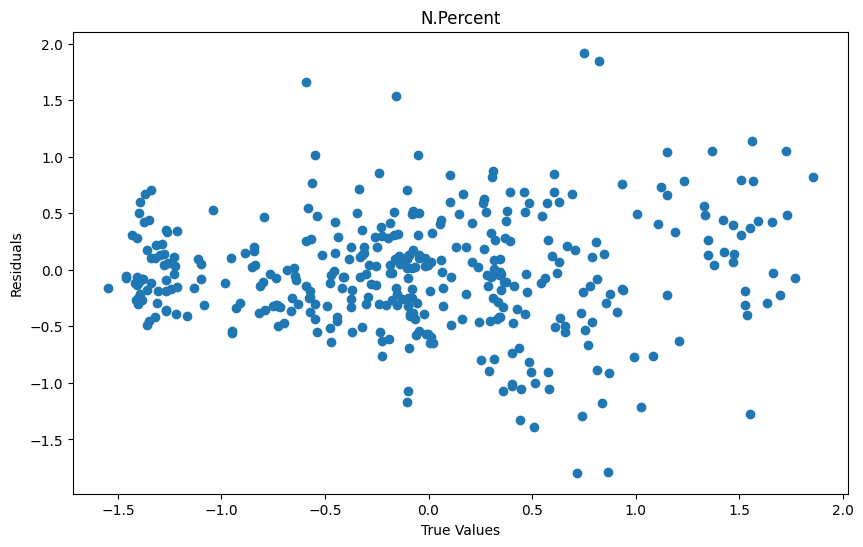

Best parameters: {'learning_rate': 0.05, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.8}
R-squared: 0.65


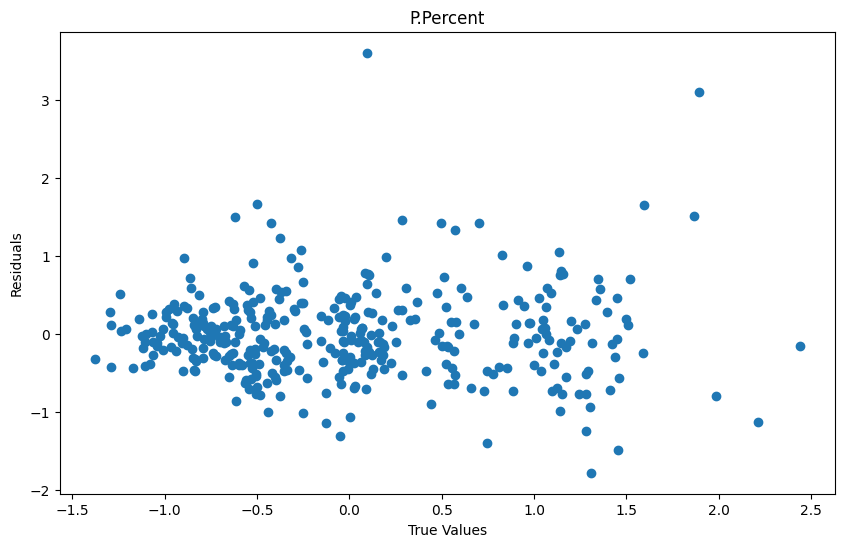

Best parameters: {'learning_rate': 0.01, 'max_features': 0.5, 'n_estimators': 500, 'subsample': 1.0}
R-squared: 0.48


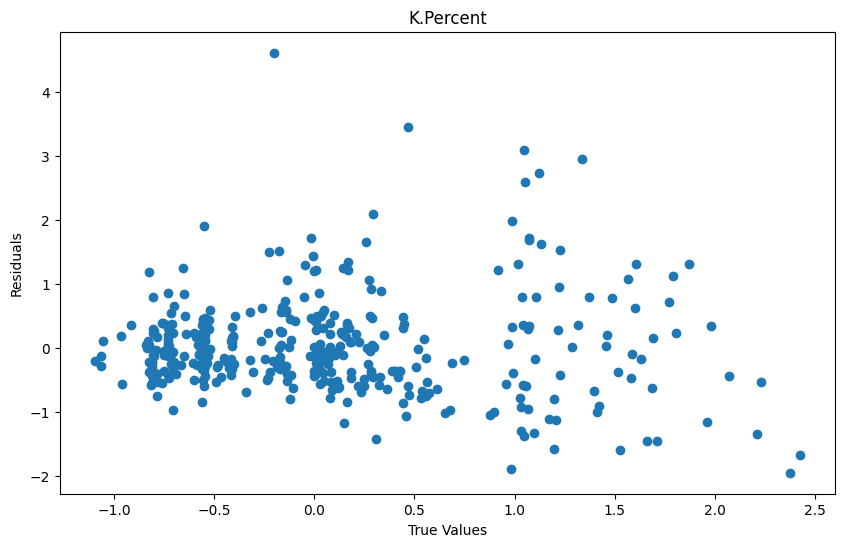

Best parameters: {'learning_rate': 0.1, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 0.8}
R-squared: 0.81


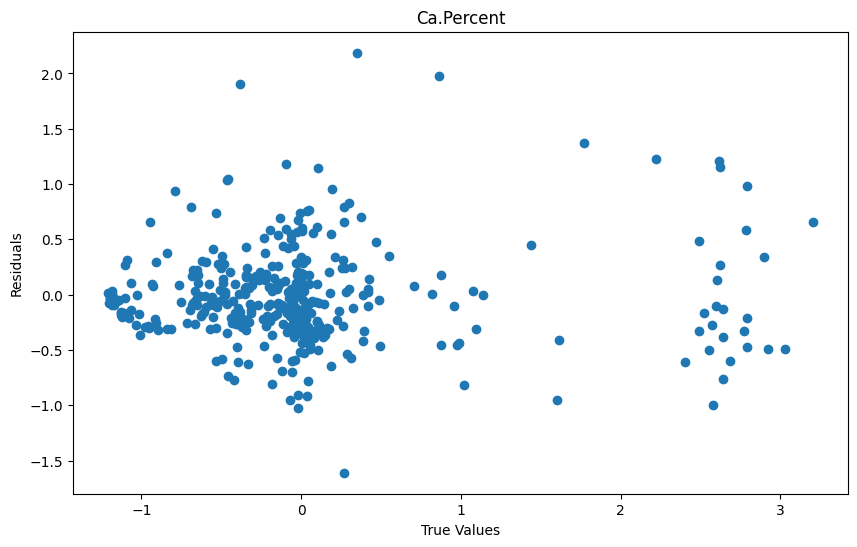

Best parameters: {'learning_rate': 0.05, 'max_features': 0.5, 'n_estimators': 300, 'subsample': 1.0}
R-squared: 0.45


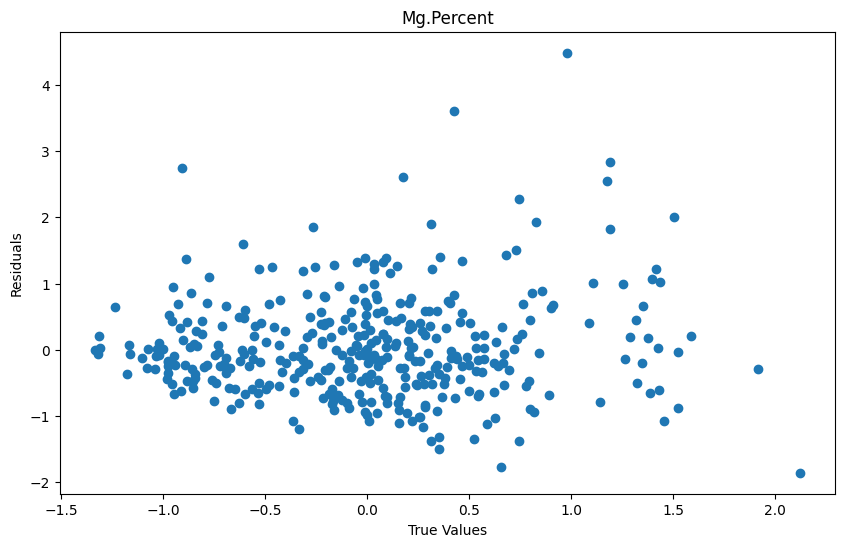

Best parameters: {'learning_rate': 0.05, 'max_features': 0.5, 'n_estimators': 300, 'subsample': 0.8}
R-squared: 0.57


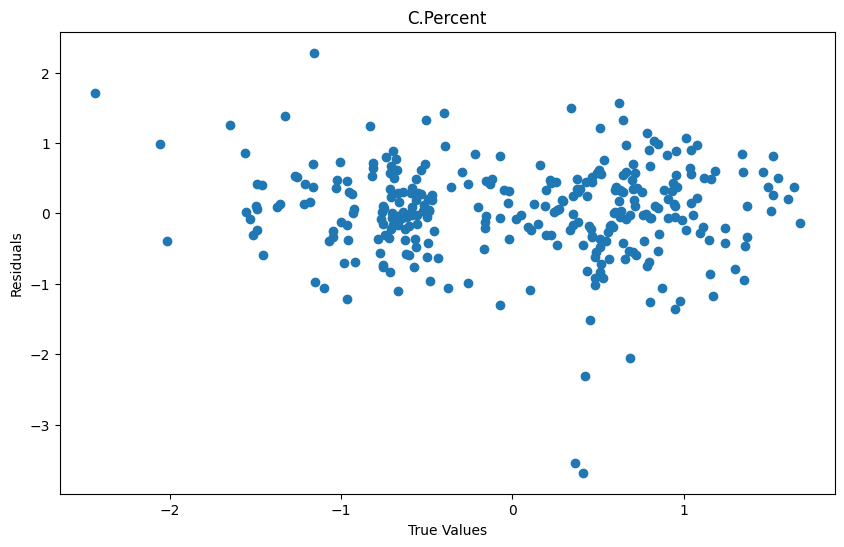

Best parameters: {'learning_rate': 0.05, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 1.0}
R-squared: 0.68


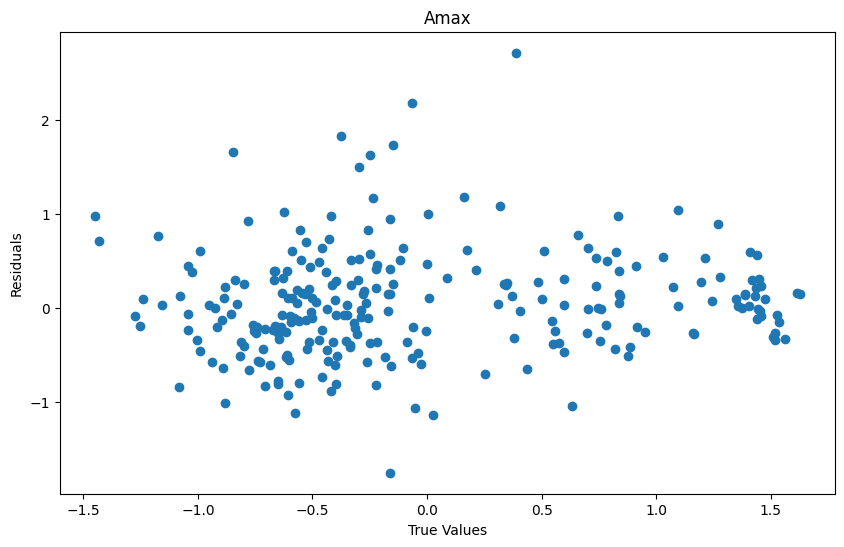

Best parameters: {'learning_rate': 0.05, 'max_features': 0.5, 'n_estimators': 100, 'subsample': 0.8}
R-squared: 0.52


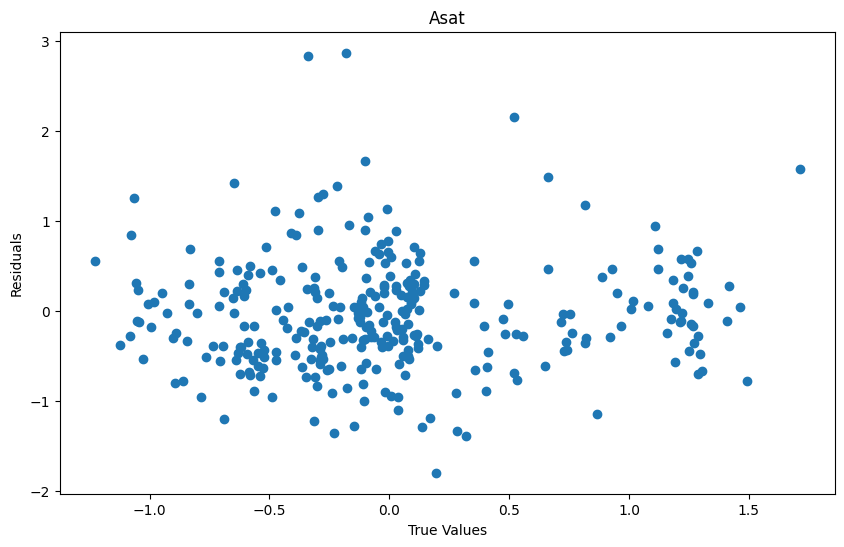

Best parameters: {'learning_rate': 0.05, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 1.0}
R-squared: 0.45


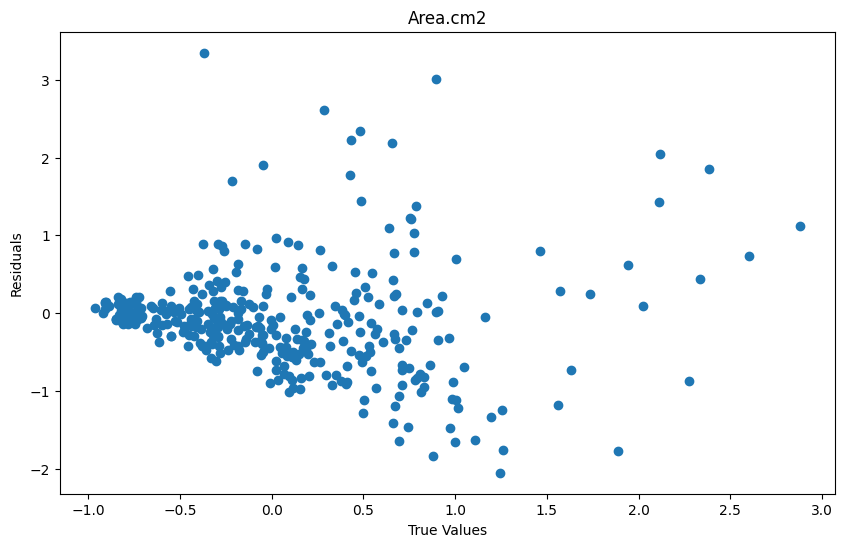

Best parameters: {'learning_rate': 0.01, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.8}
R-squared: 0.13


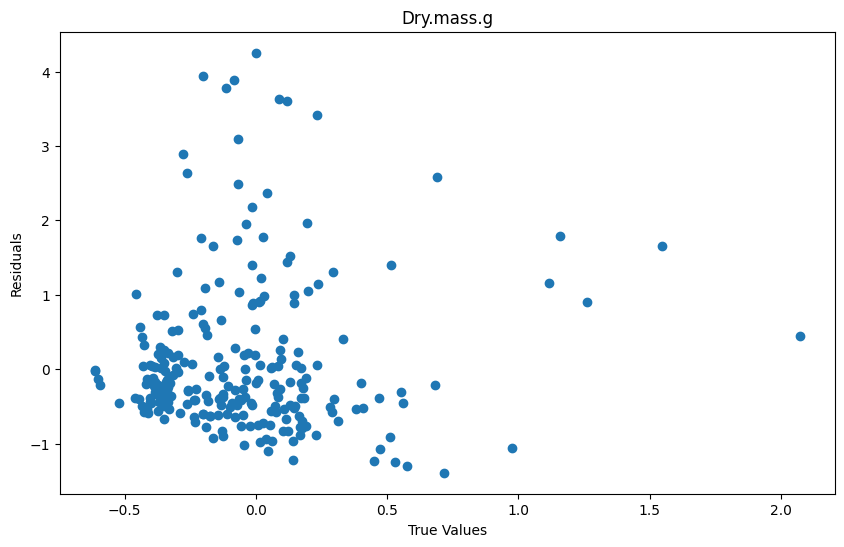

Best parameters: {'learning_rate': 0.05, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 1.0}
R-squared: 0.31


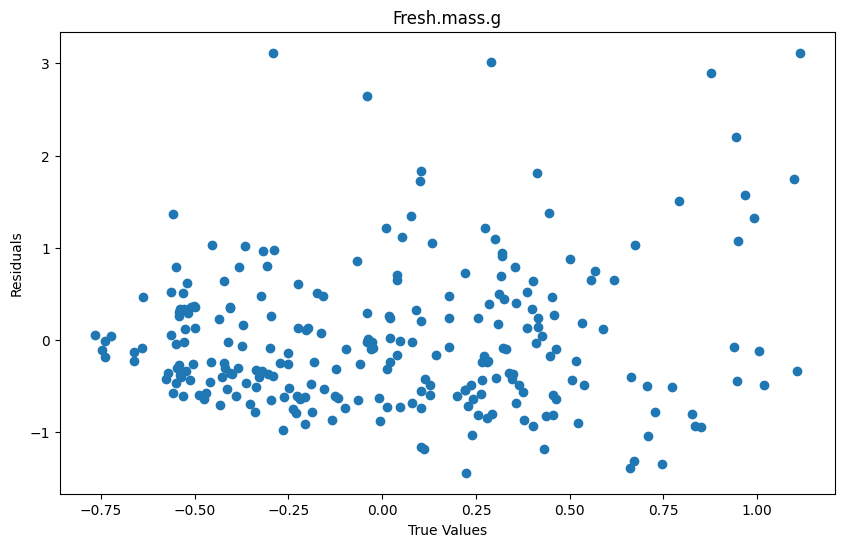

Best parameters: {'learning_rate': 0.05, 'max_features': 'sqrt', 'n_estimators': 500, 'subsample': 1.0}
R-squared: 0.58


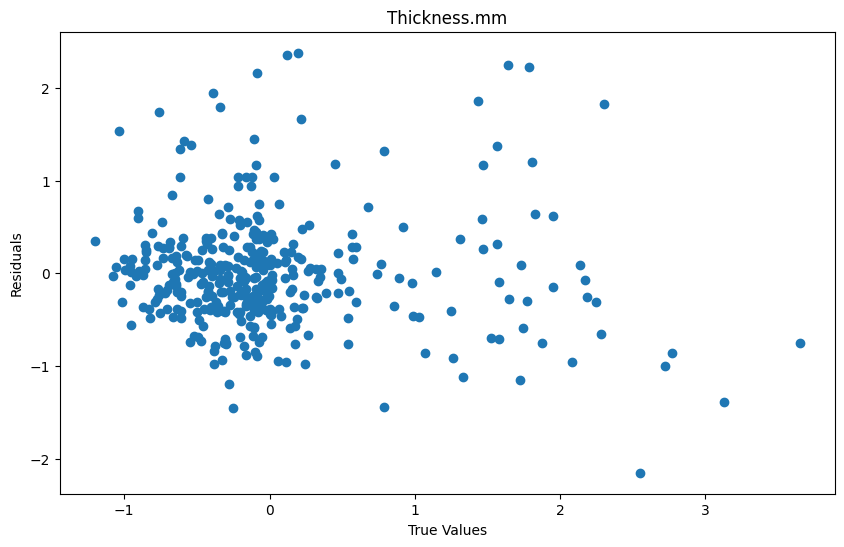

Best parameters: {'learning_rate': 0.05, 'max_features': 0.5, 'n_estimators': 100, 'subsample': 1.0}
R-squared: 0.36


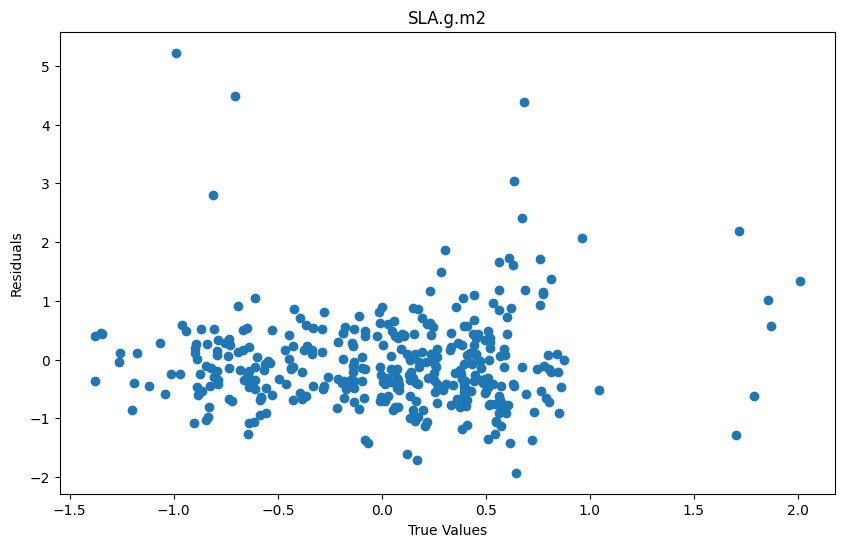

In [19]:
for var in VARS:
    dataset = LabelledTraitData(
        data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
        var=var
    )

    X_test, y_test = GBDTAuxAndBands.configure_data(dataset.test_data, dataset.test_labels)

    # Get the best parameters
    best_params = aux_too_best_params[var]
    print(f"Best parameters: {best_params}")
    # Get the best model
    best_rf = aux_too_best_estimators[var]
    # Predict the trait values
    predictions = best_rf.predict(X_test)
    # Calculate metrics.
    r_squared = best_rf.score(X_test, y_test)
    print(f"R-squared: {r_squared:.2f}")

    fig = plot_residuals(y_test, predictions, var)
    plt.savefig(f"../figures/models/residuals_{var}_GBDTauxvars.png")
    plt.show()